In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [27]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.features import build_features

warnings.filterwarnings("ignore")

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Objetivo del cuadernillo

En este cuadernillo se quiere realizar el preprocesamiento de los datos de egresos hospitalarios para confeccionar un modelo de previsión de esta métrica hasta el 2035. De forma general, se utilizarán los datos desde 2001 hasta 2018 para entrenar modelos, y 2019 para evaluar los modelos. Se obviará 2020 del análisis debido a la naturaleza del año (pandemia).

- Se entrenarán 6 modelos distintos, y se seleccionará el que tenga el mejor desempeño en el conjunto de evaluación (año 2019). Los modelos a entrenar serán:

  - Prophet
  - Auto ARIMA
  - XGB
  - Hibrido
  - Feed Forward Neural Network
  - Long-Short Term Memory (LSTM)

Para simplificar el modelamiento de los datos, se harán las predicciones con una agregación de egresos mensuales.


In [3]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

In [4]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [5]:
# Obtiene metricas agregadas por mes (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("M").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_MAS_RELEVANTES)]
    .resample("M")
    .sum()[["n_egresos"]]
)

# 1. Preprocesamiento de los datos

Cada uno de los modelos requiere un preprocesamiento distinto de los datos. Por lo tanto, se creará un apartado para cada uno.


In [6]:
# Previo a cualquier preprocesamiento, se separa en train y test
CORTE_TEST = "2019-01-01"

train = df[df.index < CORTE_TEST]
test = df[df.index >= CORTE_TEST]

In [7]:
from prophet import Prophet
from pmdarima.arima import auto_arima
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

Importing plotly failed. Interactive plots will not work.


## Prophet


In [23]:
# Preprocesa datos Prophet
train_prophet = train.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
test_prophet = test.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})

In [24]:
# Entrena datos en Prophet
prophet = Prophet()
prophet.add_country_holidays("Chile")
prophet.fit(train_prophet)

14:49:29 - cmdstanpy - INFO - Chain [1] start processing
14:49:29 - cmdstanpy - INFO - Chain [1] done processing


MAE train: 27.53 egresos - MAPE train: 0.07
MAE test: 35.46 egresos - MAPE test: 0.08


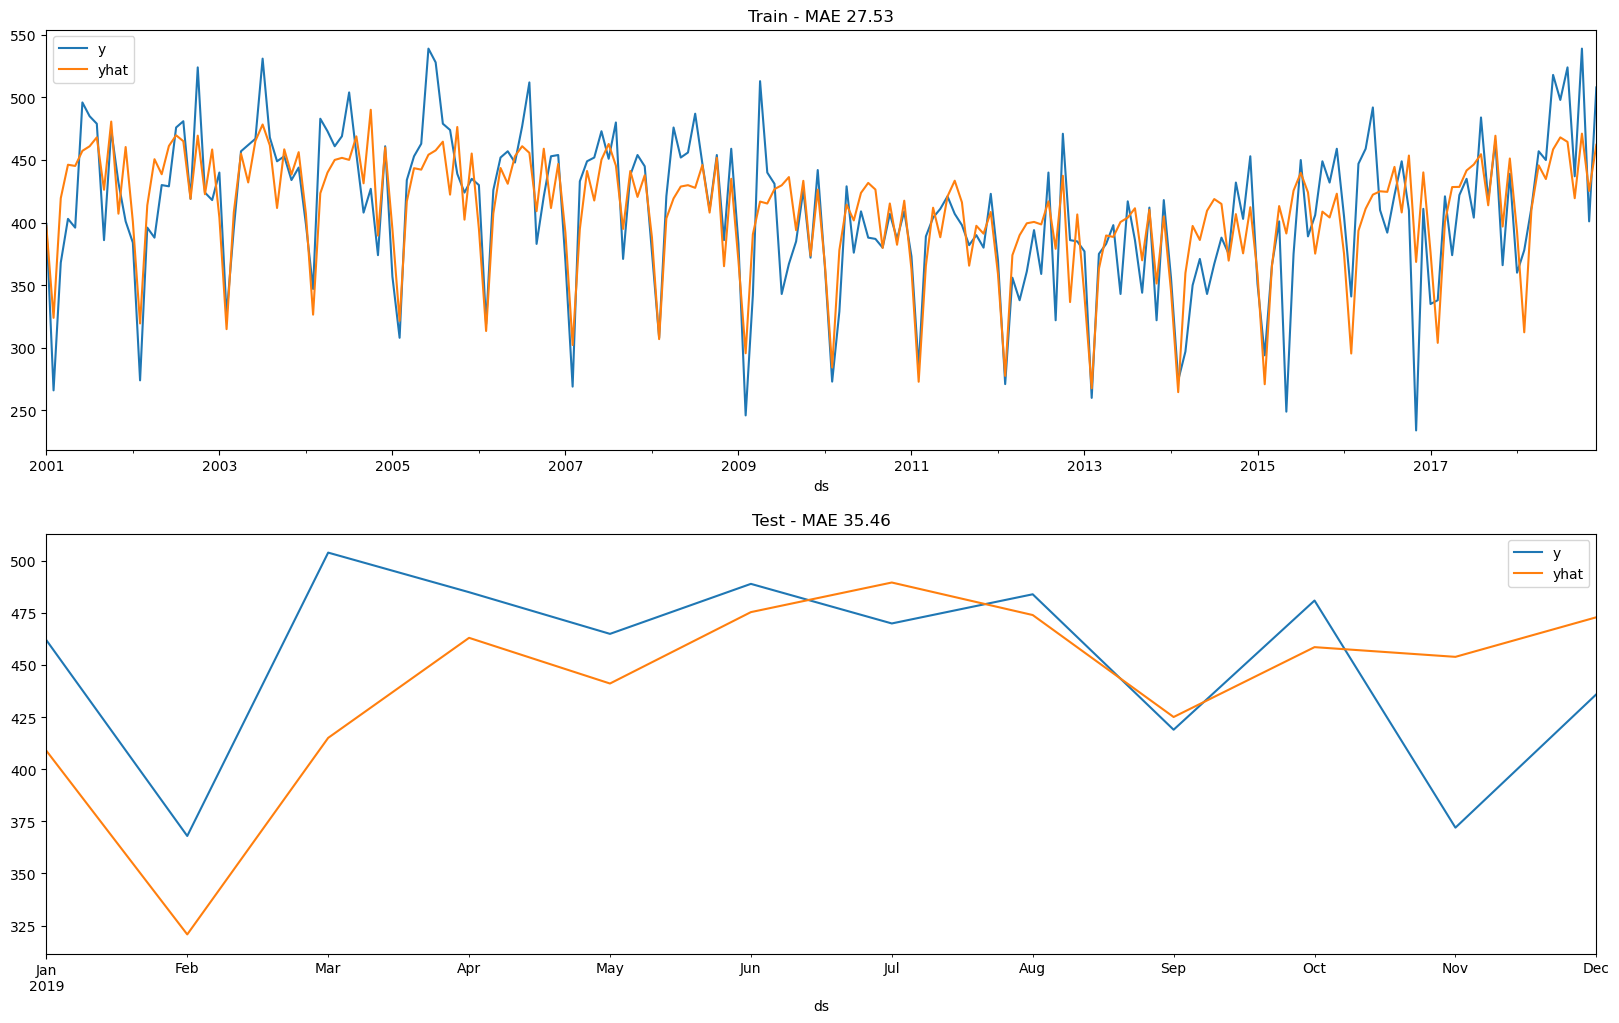

In [28]:
# Evalua metricas de rendimiento en train y test
yhat_train_prophet = prophet.predict(train_prophet)
yhat_test_prophet = prophet.predict(test_prophet)

mae_train = mean_absolute_error(train_prophet["y"], yhat_train_prophet["yhat"])
mae_test = mean_absolute_error(test_prophet["y"], yhat_test_prophet["yhat"])

mape_train = mean_absolute_percentage_error(train_prophet["y"], yhat_train_prophet["yhat"])
mape_test = mean_absolute_percentage_error(test_prophet["y"], yhat_test_prophet["yhat"])

print(f"MAE train: {mae_train:.2f} egresos - MAPE train: {mape_train:.2f}")
print(f"MAE test: {mae_test:.2f} egresos - MAPE test: {mape_test:.2f}")

# Grafica rendimiento de modelo
train_prophet["yhat"] = yhat_train_prophet["yhat"]
test_prophet["yhat"] = yhat_test_prophet["yhat"]

fig, axis = plt.subplots(2, 1, figsize=(20, 12))
train_prophet.set_index("ds").plot(ax=axis[0])
test_prophet.set_index("ds").plot(ax=axis[1])

axis[0].title.set_text(f"Train - MAE {mae_train:.2f}")
axis[1].title.set_text(f"Test - MAE {mae_test:.2f}")

## Auto ARIMA


In [ ]:
train_auto_arima = train["n_egresos"]
test_auto_arima = test["n_egresos"]

## XGB


In [ ]:
# Agrega los lags significativos segun grafico de autocorrelacion
LAGS_A_AGREGAR = [1, 2, 3, 11, 12, 24]

train_xgb = build_features.add_time_series_columns(train)
train_xgb = build_features.create_lag_features(train_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

test_xgb = build_features.add_time_series_columns(test)
test_xgb = build_features.create_lag_features(test_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

## Feed Forward Neural Network


In [ ]:
SEQ_SIZE = 3
n_features = 1

train_ff_nn = TimeseriesGenerator(train, train, length=SEQ_SIZE, batch_size=n_features)
test_ff_nn = TimeseriesGenerator(test, test, length=SEQ_SIZE, batch_size=n_features)

## Long Short Term Memory


In [ ]:
SEQ_SIZE = 3
n_features = 1

train_lstm = TimeseriesGenerator(train, train, length=SEQ_SIZE, batch_size=n_features)
test_lstm = TimeseriesGenerator(test, test, length=SEQ_SIZE, batch_size=n_features)